In [1]:
from commfunctions import *
from skimage import io, color, filters, measure
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.draw import rectangle
from numpy.linalg import norm
import numpy as np
import pickle
import cv2
from numpy.linalg import norm
from skimage.filters import *
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from notes import *
import random
from utils import *

In [2]:
from skimage import morphology

def detect_vertical_line_and_crop(image):
    # Read the image
   
    image_gray = color.rgb2gray(image)

    # Apply Otsu's thresholding
    threshold_value = filters.threshold_otsu(image_gray)
    binary_image = image_gray < threshold_value

    # Define a vertical kernel for morphological operations
    vertical_kernel = morphology.rectangle(int(image.shape[0] * 0.8), 1)

    # Detect vertical lines using morphological operations
    detected_lines = morphology.opening(binary_image, vertical_kernel)

    # Find contours of the detected lines
    contours, _ = cv2.findContours((detected_lines * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    vertical_line_x=0
    # Identify the vertical line that is 80% or more of the height
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h >= 0.8 * image.shape[0]:
            vertical_line_x = x
            break

    # Crop the image to remove pixels to the left of the detected vertical line
    cropped_image = image[:, vertical_line_x:]

    return cropped_image

In [3]:
# The function getRefLengths processes an image to compute reference lengths based on the transitions between black and white pixels in each column of the image. Here's a step-by-step explanation:

# Initialization:

# cols and rows store the number of columns and rows in the image, respectively.
# hist is a 2D histogram initialized to zeros with dimensions (rows, rows).
# Column-wise Processing:

# For each column i in the image:
# a is the column vector.
# starts identifies transitions from non-zero to zero (black to white).
# ends identifies transitions from zero to non-zero (white to black).
# starts_ix and ends_ix store the indices of these transitions, adjusted by 2.
# s1 and s2 store the sizes of starts_ix and ends_ix.
# Adjustments:

# If the first element of a is zero, prepend 1 to starts_ix.
# If the last element of a is zero, append the size of a + 1 to ends_ix.
# Length Calculations:

# l0 is the difference between ends_ix and starts_ix.
# starts_ix1 is starts_ix shifted by one position, with a padding of a.size + 1.
# l1 is the difference between starts_ix1 and the sum of starts_ix and l0.
# Histogram Update:

# For each start index, update the histogram hist at position (l0[i], l1[i]).
# Final Adjustments and Return:

# Set the first column of hist to zero.
# Find the maximum value in hist and its indices.
# Return the indices of the maximum value.
def getRefLengths(img):
    cols = img.shape[1]
    rows = img.shape[0]
    hist = np.zeros((rows, rows), dtype=np.uint32)
    
    for i in range(cols):
        a = img[:, i]
        #starts identifies transitions from non-zero to zero (black to white).
        #ends identifies transitions from zero to non-zero (white to black).
        starts = np.where((a[:-1] != 0) & (a[1:] == 0))[0] + 2
        ends = np.where((a[:-1] == 0) & (a[1:] != 0))[0] + 2
        
        if a[0] == 0:
            starts = np.append(1, starts)
        if a[-1] == 0:
            ends = np.append(ends, a.size + 1)
        
        l0 = ends - starts
        starts_shifted = np.pad(starts[1:], (0, 1), mode='constant', constant_values=(a.size + 1))
        l1 = starts_shifted - (starts + l0)
        
        for j in range(len(starts)):
            hist[l0[j], l1[j]] += 1
    
    hist[:, 0] = 0
    max_value = np.max(hist)
    max_indices = np.where(hist == max_value)
    
    return max_indices[0][0], max_indices[1][0]

In [4]:
import numpy as np
#The function getCandidateStaffs processes a binary image to identify candidate staff lines based on their height. 
def getCandidateStaffs(binaryImg, staffHeight):
    filteredImg = np.copy(binaryImg)
    candidates = []  # Contains list of candidate staffs (column, start_row, height)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    upperLimitHeight = staffHeight + 2
    lowerLimitHeight = abs(staffHeight - 2)
    flag = False
    
    for i in range(cols):
        for j in range(rows):
            if filteredImg[j, i] == 0 and not flag:
                beg = j
                flag = True
            elif filteredImg[j, i] == 1 and flag:
                flag = False
                height = j - beg
                if height > upperLimitHeight or height < lowerLimitHeight:
                    filteredImg[beg:j, i] = 1
                else:
                    candidates.append((i, beg, height))
    
    return filteredImg, candidates

In [5]:
import numpy as np

def removeLonelyStaffs(v, filteredImg, staffHeight, spaceHeight, eliminated):
    img = np.copy(filteredImg)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    staffs = np.ones(img.shape)

    for i in v.copy():
        verConnected = False
        horConnected = False

        col, begin, length = i

        # Check horizontal connections
        if col - 1 >= 0 and np.any(filteredImg[begin:begin + length, col - 1] == 0):
            horConnected = True
        if col + 1 < cols and np.any(filteredImg[begin:begin + length, col + 1] == 0):
            horConnected = True

        # Check vertical connections
        start = max(begin - (spaceHeight + staffHeight), 0)
        end = min(rows, begin + length + spaceHeight + staffHeight)
        start2 = min(rows, begin + length + spaceHeight)
        if np.any(filteredImg[start:start + staffHeight, col] == 0) or np.any(filteredImg[start2:end, col] == 0):
            verConnected = True

        # Remove lonely staff lines
        if not verConnected:
            img[begin:begin + length, col] = 1
            v.remove(i)
            eliminated.append(i)

    # Update staffs array
    for i in v:
        staffs[i[1]:i[1] + i[2], i[0]] = 0

    return staffs, v, eliminated

In [6]:
import numpy as np

def mergeContours(staffless, boundingRects, staffHeight, spaceHeight):
    taken = np.zeros((len(boundingRects),), dtype=bool)
    boundingRects = sorted(boundingRects, key=lambda b: b[0])
 
    (x, y, w, h) = boundingRects[0]
    mergedRects = [(x, y, x + w, y + h)]
    k = 0

    for i in range(1, len(boundingRects)):
        (x, y, w, h) = boundingRects[i]
        old_x, old_y, old_x2, old_y2 = mergedRects[k]
        old_w = old_x2 - old_x
        old_h = old_y2 - old_y

        if w < 2 * staffHeight and h < 2 * staffHeight:
            continue

        if ((((x - old_x2) < 0.75 * spaceHeight and (x - old_x2) >= 0) and ((old_h <= spaceHeight + staffHeight) or (h <= spaceHeight + staffHeight)))
            or (x < old_x2 and h < 3 * spaceHeight)):

            mergedRects[k] = (min(old_x, x), min(old_y, y), max(old_x2, x + w), max(old_y2, y + h))
        else:
            mergedRects.append((x, y, x + w, y + h))
            k += 1

    return mergedRects

def getHalfs(lines, spaceHeight, height):
    detected_lines = np.zeros((height,))
    detected_lines[lines] = 1

    starts = np.where((detected_lines[:-1] == 1) & (detected_lines[1:] == 0))[0] + 1
    ends = np.where((detected_lines[:-1] == 0) & (detected_lines[1:] == 1))[0]

    starts = starts[:-1]
    ends = ends[1:]

    halfs = [0]

    for i in range(len(starts)):
        diff = ends[i] - starts[i]
        if diff > 5 * spaceHeight:
            halfs.append((ends[i] + starts[i]) // 2)

    halfs.append(height - 1)
    
    return halfs

from skimage import measure
import numpy as np

def getObjects(staffless, staffHeight, spaceHeight):

    cnt, hir = cv2.findContours(staffless, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours = []
    
    for i in range(len(cnt)):

        if hir[0,i,3] == -1:
            contours.append(cnt[i])
    
    boundingRects = [cv2.boundingRect(c) for c in contours]
 
    
    mergedRects = mergeContours(staffless, boundingRects, staffHeight, spaceHeight)
 
    
    boundingRects = []
    for m in mergedRects:
        boundingRects.append([m[0],m[1], m[2]-m[0], m[3]-m[1]])

    mergedRects = mergeContours(staffless, boundingRects, staffHeight, spaceHeight)
    

    
    return mergedRects

def segmentImage(staffless, lines, staffHeight, spaceHeight):
    halfs = getHalfs(lines, spaceHeight, staffless.shape[0])
    
    boundingRects = []
    for i in range(len(halfs) - 1):
        segment = staffless[halfs[i]:halfs[i+1] + 1]
        mergedRects = getObjects(segment, staffHeight, spaceHeight)

        for b in mergedRects:
            boundingRects.append((b[0], halfs[i] + b[1],b[2], halfs[i] + b[3]))
    
    return boundingRects



In [7]:
import scipy.signal as signal
def getLines(img, staffHeight, spaceHeight):
    cp = img.copy()

    kernel = np.ones((staffHeight, 1))
    dilate = cv2.dilate(cp, kernel)

    # show_images([dilate])
    rows_sum = np.sum(dilate, axis=1)
    
    lines, _ = signal.find_peaks(rows_sum, height = 0.2*img.shape[1], distance=spaceHeight)

    return lines


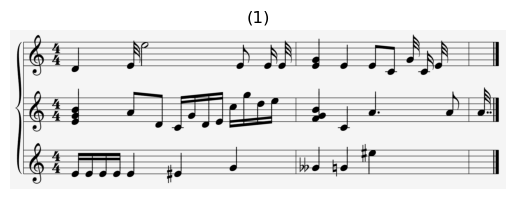

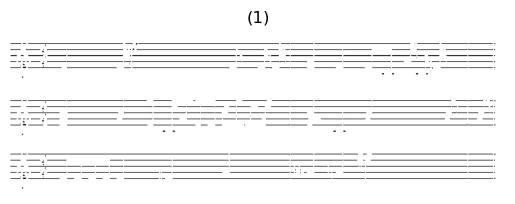

In [8]:
img = io.imread("../data/input/02.png")[...,:3] 
img2 = rgb2gray(img)
lineremoved = detect_vertical_line_and_crop(img)
lineremoved = rgb2gray(lineremoved)
binary =otsu(lineremoved)
show_images([img])
staffHeight1, spaceHeight1 =getRefLengths(binary)
staffHeight1=2; spaceHeight1=16


filteredImg1, candidates1 = getCandidateStaffs(binary, staffHeight1)
filteredImg1, candidates1, eliminated1 = removeLonelyStaffs(candidates1, binary, staffHeight1, spaceHeight1, eliminated=[])

show_images([filteredImg1])

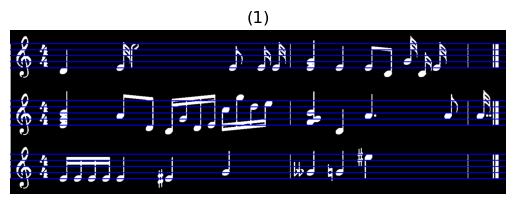

In [9]:
without_staff = (binary-filteredImg1).astype(np.uint8)

lines1 = getLines(1-filteredImg1, staffHeight1, spaceHeight1)
staff1 = cv2.cvtColor(without_staff, cv2.COLOR_GRAY2BGR)
for line in lines1:
    cv2.line(staff1,(0,line), (staff1.shape[1]-1, line), (0,0,255), staffHeight1)
show_images([staff1]) 


objects1 = segmentImage(without_staff, lines1, staffHeight1, spaceHeight1)
cropped_objects = []

for o in objects1:
    cropped = without_staff[o[1]:o[3], o[0]:o[2]]
    cropped_objects.append(cropped)
    # show_images([cropped])

# cp1 = cv2.cvtColor(without_staff, cv2.COLOR_GRAY2BGR)
# for o in objects1:
#     cv2.rectangle(cp1, (o[0],o[1]), (o[2],o[3]), (0, 255, 0), 3)
    

# show_images([cp1])

In [10]:
dataset_path = "../data/input/datasets/Dataset2"  # Replace with the correct folder structure
import os
import numpy as np
import cv2
from skimage.io import imread
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
import traceback

label2id = {
    "a_1": 0, "a_16": 1, "a_2": 2, "a_32": 3, "a_4": 4, "a_8": 5,
    "barline": 6, "chord": 7, "clef": 8, "dot": 9,
    "double_flat": 10, "double_sharp": 11, "flat": 12,
    "natural": 13, "sharp": 14, "t_4_2": 15, "t_4_4": 16
}


id2label = {
    0: "a_1", 1: "a_16", 2: "a_2", 3: "a_32", 4: "a_4", 5: "a_8",
    6: "barline", 7: "chord", 8: "clef", 9: ".", 10: "&&", 11: "##", 12: "&", 13: "", 14: "#", 
    15: r'\meter<"4/2">', 16: r'\meter<"4/4"> '
}

# load the classfier
file = open("nn2.pickle",'rb')
nn = pickle.load(file)

# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

classes = ['a_1', 'a_16', 'a_2', 'a_32', 'a_4', 'a_8', 
           'barline ', 'chord', 'clef', '.', '&&', '##', '&', '', '#', '\meter<"4/2"> ', '\meter<"4/4"> ']

def extract_hog_features(img,target_img_size):

    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

def SIFT(image):
    sift = cv2.SIFT_create()
    if image.dtype != np.uint8:
      image = (image * 255).astype(np.uint8)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors


# Load images and labels with improved error handling
def load_dataset(folder_path):
    X = []  # Features
    y = []  # Labels
    total_images = 0
    processed_images = 0

    
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if class_name=="b_16" or class_name=="b_32" or class_name=="b_8":
            continue
        if os.path.isdir(class_path):
          
            for file_name in os.listdir(class_path):
                total_images += 1
                file_path = os.path.join(class_path, file_name)
                
                try:
                    # Check file extension and readability
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                        
                        # Skip invalid images
                        if image is None:
                            print(f"Skipping invalid image: {file_path}")
                            continue
                        
                        # Extract descriptors
                        if image.ndim != 2:
                            continue
                        
                        descriptors = extract_hog_features(image,(32,32))
                        
                        # Only add if descriptors are found
                        if descriptors is not None and len(descriptors) > 0:
                            total_images+=1
                            X.append(descriptors)
                            y.append(label2id[class_name])
                            processed_images += 1
                        else:
                            print(f"No descriptors found for: {file_path}")
                
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    print(total_images)
    return X, y



import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

X,y=load_dataset(dataset_path)

# Ensure X and y are not empty
if not X or not y:
    raise ValueError("Features (X) and labels (y) cannot be empty.")

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Move tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

def knn_predict(X_train, y_train, X_test, k=3):
    # Compute distances between X_test and X_train
    distances = torch.cdist(X_test, X_train)
    
    # Get the k nearest neighbors
    knn_indices = distances.topk(k, largest=False).indices
    
    # Gather the labels of the k nearest neighbors
    knn_labels = y_train[knn_indices]
    
    # Predict the most common label
    y_pred = torch.mode(knn_labels, dim=1).values
    return y_pred

# Predict on the test set
k = 17
y_pred = knn_predict(X_train, y_train, X_test, k)

# Calculate accuracy
accuracy = (y_pred == y_test).float().mean()
print(f'Accuracy: {accuracy.item() * 100:.2f}%')

<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
/var/folders/71/sbmf51nx7hq0sz3vdq28hktm0000gn/T/ipykernel_34218/2532020230.py:38: SyntaxWarning: invalid escape sequence '\m'
  'barline ', 'chord', 'clef', '.', '&&', '##', '&', '', '#', '\meter<"4/2"> ', '\meter<"4/4"> ']
/var/folders/71/sbmf51nx7hq0sz3vdq28hktm0000gn/T/ipykernel_34218/2532020230.py:38: SyntaxWarning: invalid escape sequence '\m'
  'barline ', 'chord', 'clef', '.', '&&', '##', '&', '', '#', '\meter<"4/2"> ', '\meter<"4/4"> ']
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#se

82234


/var/folders/71/sbmf51nx7hq0sz3vdq28hktm0000gn/T/ipykernel_34218/2532020230.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)


Accuracy: 94.56%


In [11]:
def predict_image(image, X_train, y_train, k=18):
    if image is None:
        raise ValueError(f"Invalid image")
    
    descriptors = extract_hog_features(image,(32,32))
    if descriptors is None or len(descriptors) == 0:
        raise ValueError(f"No descriptors found for")
    
    X_test = torch.tensor([descriptors], dtype=torch.float32).to(device)
    y_pred = knn_predict(X_train, y_train, X_test, k)
    return y_pred.item()

In [12]:
predictions = [predict_image(img, X_train=X_train, y_train=y_train) for img in cropped_objects]
labels = [id2label[pred] for pred in predictions]

In [13]:
id2label2 = {
    0: "a_1", 1: "a_16", 2: "a_2", 3: "a_32", 4: "a_4", 5: "a_8",
    6: "barline", 7: "chord", 8: "clef", 9: "dot",
    10: "double_flat", 11: "double_sharp", 12: "flat",
    13: "natural", 14: "sharp", 15: "t_4_2", 16: "t_4_4"
}

temp = [id2label2[pred] for pred in predictions]

print(temp)

['dot', 'clef', 't_4_4', 'a_4', 'a_32', 'a_2', 'a_8', 'a_16', 'a_32', 'chord', 'a_4', 'a_4', 'a_4', 'a_32', 'a_16', 'a_32', 'dot', 'dot', 'dot', 'dot', 'clef', 't_4_4', 'chord', 'a_4', 'a_2', 'barline', 'chord', 'chord', 'a_4', 'a_8', 'a_8', 'chord', 'a_32', 'dot', 'dot', 'dot', 'clef', 't_4_4', 'a_2', 'a_4', 'sharp', 'a_4', 'a_4', 'chord', 'flat', 'a_4', 'natural', 'a_4', 'sharp', 'a_4', 'chord', 'dot', 'dot']


In [14]:
from commfunctions import * 

def isDot(img, spaceHeight):
    if img.shape[0] > spaceHeight:
        return False
    return True

def chord2text(img,cnt_pos,staffHeight,spaceHeight,lines):
    char_middle = ''
    char_top = ''
    char_down = ''
    height = cnt_pos[1] - cnt_pos[0]
    if height > 2.75 * spaceHeight: 
        # height of 3 notes
        middle = img[img.shape[0]//3:img.shape[0]*2//3,staffHeight:img.shape[1]-staffHeight]
       
        #get top and down
        _, top, distanceTop = getNearestLine(cnt_pos[0],lines)
        _, bottom, distanceBottom = getNearestLine(cnt_pos[0] + height //3 ,lines)
        char_top = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
        _, top, distanceTop = getNearestLine(cnt_pos[0] + height*2//3,lines)
        _, bottom, distanceBottom = getNearestLine((cnt_pos[1]),lines)
        char_down = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
        if np.sum(middle) > len(middle)//2:
            # there's a note in middle 
            _, top, distanceTop = getNearestLine(cnt_pos[0] + height //3 ,lines)
            _, bottom, distanceBottom = getNearestLine(cnt_pos[0] + height*2//3,lines)
            char_middle = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
    elif height < 1.5 * spaceHeight:
        # heigth of 1 note
        # don't think it shoud come here but anyway
        _, top, distanceTop = getNearestLine(cnt_pos[0],lines)
        _, bottom, distanceBottom = getNearestLine(cnt_pos[1],lines)
        char_down = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
    else: 
        _, top, distanceTop = getNearestLine(cnt_pos[0],lines)
        _, bottom, distanceBottom = getNearestLine(cnt_pos[0]+ height//2,lines)
        char_top = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
        _, top, distanceTop = getNearestLine(cnt_pos[0]+height//2,lines)
        _, bottom, distanceBottom = getNearestLine(cnt_pos[1],lines)
        char_down = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
        # height of 2 notes
    return str(char_down) + str(char_middle) + str(char_top)


def getchordText(cnt_pos,cnt_img,staffHeight,spaceHeight,lines):
    h_hist = np.sum(cnt_img,axis=0)
    bar_idx = np.where(h_hist== np.max(h_hist))[0][0]
    img = binary_opening(cnt_img.copy(),np.ones((staffHeight,cnt_img.shape[1]//2)))

    if ((bar_idx >  cnt_img.shape[1]//2 -staffHeight) and (bar_idx < cnt_img.shape[1]//2+staffHeight)):
        # chord is two sides 
        rh = img[:,:bar_idx] #right half
        rh = binary_opening(rh.copy(),np.ones((staffHeight,rh.shape[1]//2)))
        lh = img[:,bar_idx:] # left half 
        lh = binary_opening(lh.copy(),np.ones((staffHeight,lh.shape[1]//2)))
        # apply on right half
        hist = np.sum(rh,axis=1)
        idxs = np.where(hist > staffHeight)
        min_y = idxs[0][0]
        max_y = idxs[0][len(idxs[0])-1]+1
        rcnt_pos = [min_y+cnt_pos[0],max_y+cnt_pos[0]]
        text1 = chord2text(img,rcnt_pos,staffHeight,spaceHeight,lines)
        #apply on left half
        hist = np.sum(lh,axis=1)
        idxs = np.where(hist > staffHeight)
        min_y = idxs[0][0]
        max_y = idxs[0][len(idxs[0])-1]+1
        lcnt_pos = [min_y+cnt_pos[0],max_y+cnt_pos[0]]     
        text2 = chord2text(img,lcnt_pos,staffHeight,spaceHeight,lines)
        return "".join(sorted(text1 + text2))
    else:
        # chor is one side
        hist = np.sum(img,axis=1)
        idxs = np.where(hist > staffHeight)
        min_y = idxs[0][0]
        max_y = idxs[0][len(idxs[0])-1]+1
        cnt_pos = [min_y+cnt_pos[0],max_y+cnt_pos[0]]
        return "".join(sorted(chord2text(img,cnt_pos,staffHeight,spaceHeight,lines)))


def isHalf(img, spaceHeight):
    w = img.shape[1]
    h = img.shape[0]
    hist = np.zeros((w,4), dtype=np.uint32)
    min_x, max_x = 0, w
    min_y, max_y = 0, h 
    for i in range(w):
        window = img[:, i: min(i + 1, w)]
    #     show_images([window])
        xprojection = np.sum(window, axis=1)
    #     xprojection = np.where(xprojection>spaceHeight//4, 1,0)

        starts = np.array((xprojection[:-1] == 0) & (xprojection[1:] != 0))
        starts_ix = np.where(starts)[0] + 1
        ends = np.array((xprojection[:-1] != 0) & (xprojection[1:] == 0))
        ends_ix = np.where(ends)[0]

        if xprojection[0] != 0:
            starts_ix = np.append(0, starts_ix)

        if xprojection[-1] != 0:
            ends_ix = np.append(ends_ix, xprojection.size-1)

        if starts_ix.size != 0:
            index = np.argmax(ends_ix - starts_ix)
            hist[i,1] = min_x + i
            hist[i,2] = min_y + starts_ix[index]
            hist[i,3] = min_y + ends_ix[index]
            length = hist[i,3] - hist[i,2]
            if 0.5*spaceHeight < length < spaceHeight*1.5:
                hist[i,0] = length
    projections = len(np.where(hist[:,0]>0)[0])
    if projections > img.shape[1]//3:
        return False
    else:
        return True

def downSize(image, width=1000):
    (h, w) = image.shape[:2]
    print(h, w)
    shrinkingRatio = width / float(w)
    dsize  = (width, int(h * shrinkingRatio))
    resized = cv2.resize(image, dsize , interpolation=cv2.INTER_AREA)
    return resized  

In [17]:
firstTime = True
output = ""
perviousAccedental = ""
idx = 0
for o in objects1:
    features = extract_hog_features(without_staff[o[1]:o[3], o[0]:o[2]],(32,32))
    symbol_name = labels[idx]; idx+=1
    # symbol_name = classes[np.argmax( nn.predict_proba([features]))]
    # print('symbols:',symbol_name + ', ')

#     show_images([without_staff[o[1]:o[3], o[0]:o[2]]])
    if symbol_name == "a_2" or symbol_name == "a_4":
        if isHalf(without_staff[o[1]:o[3], o[0]:o[2]],spaceHeight1) :
            symbol_name = "a_2"
        else:
            symbol_name = "a_4"
    if symbol_name =="clef":
        if firstTime:
            firstTime = False
            output+= '['
        else:
            output+= '],\n['
    elif firstTime:
#         print('contin')
        continue 
    #beam
    elif (o[2]-o[0]) > 4*spaceHeight1:
        try:
            output += getNoteCharacter(without_staff, o, "beam", lines1, staffHeight1, spaceHeight1)+" "
        except Exception as e:
                print(f"Error occurred: {e}")
        continue
    #dot and barline
    elif symbol_name == "." or symbol_name == "barline ":
            if isDot(without_staff[o[1]:o[3], o[0]:o[2]],spaceHeight1):
                output += "."

    #chord
    elif symbol_name == "chord":
#             print("chord")
        try:
            notes = getchordText([o[1],o[3]],without_staff[o[1]:o[3], o[0]:o[2]],staffHeight1,spaceHeight1,lines1)
        except:
            noteSymbol = getNoteCharacter(without_staff, o, "a_4", lines1, staffHeight1, spaceHeight1)

            output += noteSymbol[0]+perviousAccedental+noteSymbol[1:]+" "
            perviousAccedental = ""

            continue
        output +="{"
        for k in range(0,len(notes)-2,2):
            output += notes[k:k+2]+"/4,"
        output += notes[-2:]+"/4"
        output+= "} "

    #note
    elif symbol_name!="" and  symbol_name[0]=="a" :
        try:
            noteSymbol = getNoteCharacter(without_staff, o, symbol_name, lines1, staffHeight1, spaceHeight1)
            output += noteSymbol[0]+perviousAccedental+noteSymbol[1:]+" "
            perviousAccedental = ""
        except:
#   
            continue
    #accedentals
    elif symbol_name == r'\meter<"4/2"> ' or symbol_name == r'\meter<"4/4"> ':
        output += symbol_name
    else:

        perviousAccedental= symbol_name
output+="]"
if len(output.split("\n"))>1:
    output ="{\n"+output+"\n}"
print(output)


{
[\meter<"4/4"> d/4 e/32 e/8 e/16 e/32 b/4 e/4  g/32 c/16 e/32 ],
[\meter<"4/4"> {be/4,eg/4}    b/4 {bg/4,gg/4} c/4 a/8 a/8 b/4 a/32 ],
[\meter<"4/4">  e/4 e#/4 g/4 b/4 g&/4 g/4 e#2/4 b/4 ]
}
